In [40]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [48]:
# ============ 0) 读入并标准化 ============

def data_format(_df: pd.DataFrame) -> pd.DataFrame:
    _df = _df.copy()
    _df['Date'] = pd.to_datetime(_df['Date'], format='%d/%m/%Y', errors='coerce')

    for col in ['Price', 'Open', 'High', 'Low']:
        if col in _df.columns:
            if not np.issubdtype(_df[col].dtype, np.number):
                _df[col] = (_df[col].astype(str)
                            .str.replace(',', '', regex=False)
                            .str.replace(' ', '', regex=False))
                _df[col] = pd.to_numeric(_df[col], errors='coerce')

    if 'Change %' in _df.columns:
        _df['Change %'] = (_df['Change %'].astype(str)
                           .str.replace('%', '', regex=False)
                           .str.replace(',', '', regex=False))
        _df['Change %'] = pd.to_numeric(_df['Change %'], errors='coerce') / 100.0

    _df = _df.dropna(subset=['Date', 'Price'])
    _df = _df.set_index('Date').sort_index()

    # 去重
    _df = _df[~_df.index.duplicated(keep='last')]

    # 强制为月末标签（避免文件里混了月初/月中）
    # 如果你的数据本来就是月度，这一步不会改变价格，只会统一 index 标签
    _df = _df.resample("ME").last().dropna(subset=["Price"])

    return _df


# ============ 1) MA-regime：更“像牛市周期”的版本（去条纹 / 去假阳性） ============

def extract_bull_cycles_ma(
    price_m: pd.Series,
    ma_months: int = 12,
    slope_months: int = 6,
    min_12m_ret: float = 0.10,        # 10% YoY门槛，过滤弱反弹
    min_len_months: int = 12,         # 至少12个月，过滤短噪声
    merge_gap_months: int = 3,        # 合并最多3个月的短暂“假熊”
    confirm_in: int = 2,              # 连续2个月满足才进入 bull
    confirm_out: int = 2,             # 连续2个月不满足才退出 bull
    require_positive_total: bool = True,  # bull周期总收益必须为正
):
    """
    更稳健的 bull regime：
      base = (P > MA) & (MA slope > 0) & (12m ret > min_12m_ret)
      + hysteresis：confirm_in / confirm_out
      + min_len_months：过滤短周期
      + merge_gap_months：合并短暂中断
      + require_positive_total：剔除总收益为负的“假牛”
    """
    p = price_m.dropna().copy()
    p = p[~p.index.duplicated(keep="last")]
    p = p.sort_index()

    ma = p.rolling(ma_months).mean()
    ma_slope = ma.pct_change(slope_months)
    r12 = p.pct_change(12)

    base = (p > ma) & (ma_slope > 0) & (r12 > min_12m_ret)
    base = base.fillna(False)

    # ---- hysteresis 状态机 ----
    bull = pd.Series(False, index=p.index)
    in_count = 0
    out_count = 0
    state = False

    for i, dt in enumerate(p.index):
        flag = bool(base.iloc[i])

        if not state:
            in_count = in_count + 1 if flag else 0
            if in_count >= confirm_in:
                state = True
                out_count = 0
        else:
            out_count = out_count + 1 if (not flag) else 0
            if out_count >= confirm_out:
                state = False
                in_count = 0

        bull.iloc[i] = state

    # ---- 连续 True 分段 ----
    idx = bull.index
    x = bull.values
    segs = []
    i = 0
    while i < len(x):
        if x[i]:
            j = i
            while j < len(x) and x[j]:
                j += 1
            start = idx[i]
            end = idx[j - 1]
            n = (end.to_period("M") - start.to_period("M")).n + 1
            if n >= min_len_months:
                segs.append([start, end, n])
            i = j
        else:
            i += 1

    ep = pd.DataFrame(segs, columns=["start", "end", "n_months"])
    if ep.empty:
        return ep, bull

    # ---- 合并小间隔（避免假熊打断）----
    ep = ep.sort_values("start").reset_index(drop=True)
    merged = [ep.loc[0].to_dict()]
    for k in range(1, len(ep)):
        cur = ep.loc[k]
        last = merged[-1]
        gap = (pd.Timestamp(cur["start"]).to_period("M") - pd.Timestamp(last["end"]).to_period("M")).n - 1
        if gap <= merge_gap_months:
            last["end"] = cur["end"]
            last["n_months"] = (pd.Timestamp(last["end"]).to_period("M") - pd.Timestamp(last["start"]).to_period("M")).n + 1
            merged[-1] = last
        else:
            merged.append(cur.to_dict())
    ep = pd.DataFrame(merged)

    # ---- 计算周期收益 ----
    ep["start_price"] = ep["start"].map(p)
    ep["end_price"] = ep["end"].map(p)
    ep["total_return"] = ep["end_price"] / ep["start_price"] - 1.0
    ep["years"] = ep["n_months"] / 12.0

    # ---- 剔除总收益为负的“假牛” ----
    if require_positive_total:
        ep = ep.loc[ep["total_return"] > 0].reset_index(drop=True)

    return ep, bull


# ============ 2) 汇总打印 ============

def summarize_cycles(ep: pd.DataFrame, name: str):
    if ep.empty:
        print(f"\n[{name}] No cycles found under current parameters.")
        return

    out = ep[['start','end','n_months','years','total_return']].copy()
    out['total_return_%'] = 100*out['total_return']
    out = out.drop(columns=['total_return']).sort_values('start')

    print(f"\n[{name}] cycles:")
    print(out.to_string(index=False))

    print(f"\n[{name}] duration summary (months):")
    print(out['n_months'].describe().round(2))
    print(f"\n[{name}] duration summary (years):")
    print(out['years'].describe().round(2))


# ============ 3) 运行 ============

gold_m = pd.read_csv('/Users/henrywzh/Desktop/Data/Gold Historical Data.csv')
silver_m = pd.read_csv('/Users/henrywzh/Desktop/Data/Silver Historical Data.csv')
copper_m = pd.read_csv('/Users/henrywzh/Desktop/Data/Copper Historical Data.csv')

gold_m = data_format(gold_m)
silver_m = data_format(silver_m)
copper_m = data_format(copper_m)

gold_price = gold_m['Price']
silver_price = silver_m['Price']
copper_price = copper_m['Price']

# MA-regime（更像“牛市周期”）
gold_A, gold_bull = extract_bull_cycles_ma(
    gold_price,
    ma_months=12,
    slope_months=6,
    min_12m_ret=0.10,
    min_len_months=9,
    merge_gap_months=6,
    confirm_in=2,
    confirm_out=2,
    require_positive_total=True
)

silver_A, silver_bull = extract_bull_cycles_ma(
    silver_price,
    ma_months=12,
    slope_months=6,
    min_12m_ret=0.10,
    min_len_months=9,
    merge_gap_months=6,
    confirm_in=2,
    confirm_out=2,
    require_positive_total=True
)

# copper_A, copper_bull = extract_bull_cycles_ma(
#     copper_price,
#     ma_months=12,
#     slope_months=6,
#     min_12m_ret=0.10,
#     min_len_months=12,
#     merge_gap_months=3,
#     confirm_in=2,
#     confirm_out=2,
#     require_positive_total=True
# )

summarize_cycles(gold_A, "GOLD (MA-regime, robust)")
summarize_cycles(silver_A, "SILVER (MA-regime, robust)")
# summarize_cycles(copper_A, "COPPER (MA-regime, robust)")



[GOLD (MA-regime, robust)] cycles:
     start        end  n_months    years  total_return_%
1977-04-30 1980-12-31        45 3.750000      305.067568
1986-08-31 1988-01-31        18 1.500000       16.577676
2002-03-31 2004-05-31        27 2.250000       30.029635
2005-07-31 2008-08-31        38 3.166667       91.647545
2009-09-30 2012-04-30        32 2.666667       64.886555
2019-07-31 2021-02-28        20 1.666667       20.239254
2023-08-31 2025-12-31        29 2.416667      121.633857

[GOLD (MA-regime, robust)] duration summary (months):
count     7.00
mean     29.86
std       9.55
min      18.00
25%      23.50
50%      29.00
75%      35.00
max      45.00
Name: n_months, dtype: float64

[GOLD (MA-regime, robust)] duration summary (years):
count    7.00
mean     2.49
std      0.80
min      1.50
25%      1.96
50%      2.42
75%      2.92
max      3.75
Name: years, dtype: float64

[SILVER (MA-regime, robust)] cycles:
     start        end  n_months    years  total_return_%
1977-11-30 19

In [103]:
import matplotlib.dates as mdates

def format_year_ticks(step_years: int = 5):
    """
    step_years=2 -> 每2年一个刻度（你要的效果）
    可改成 1/5/10 等
    """
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=step_years))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator())  # 每年一个minor tick（可选）
    plt.xticks(rotation=0)  # 如想更紧凑可以 rotation=45

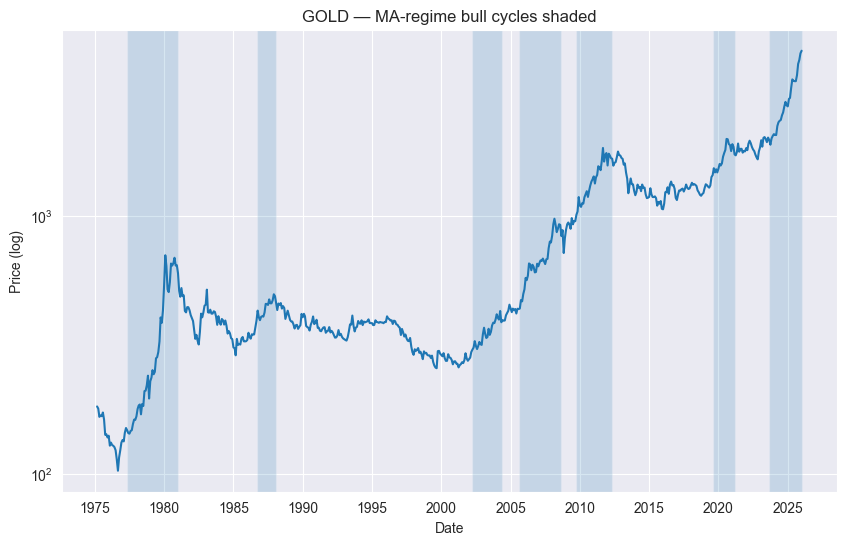

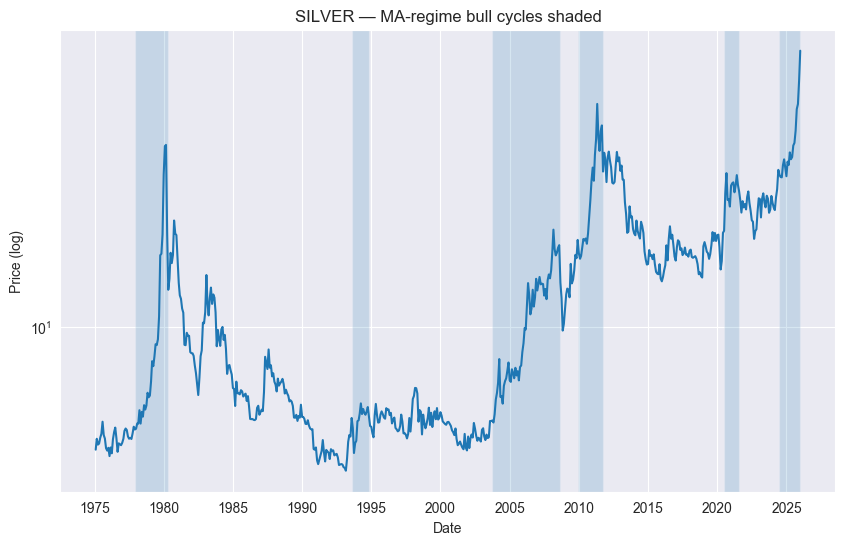

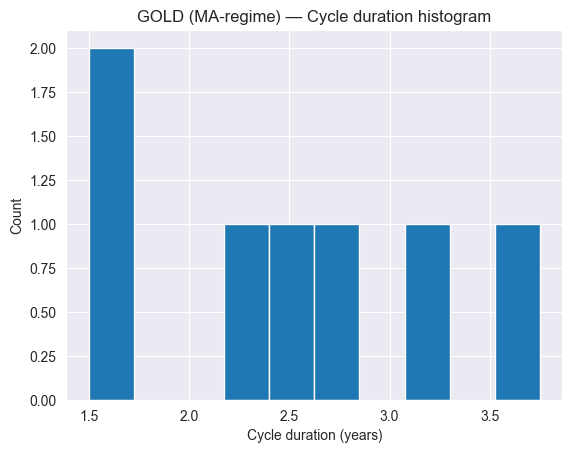

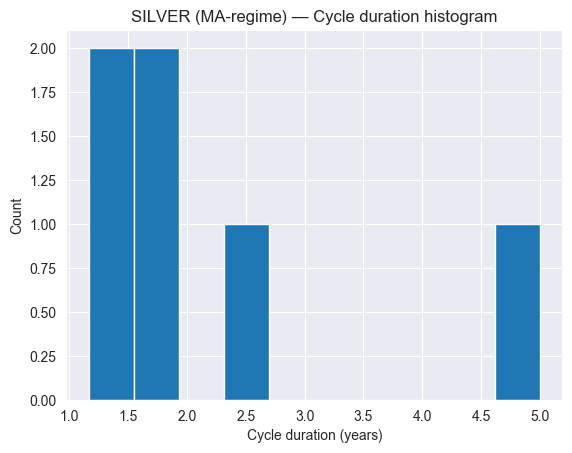

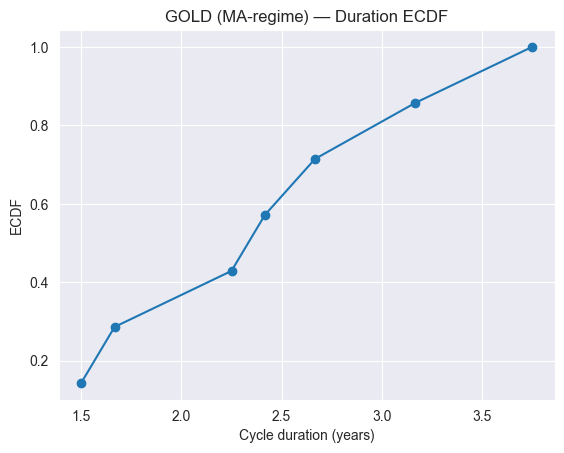

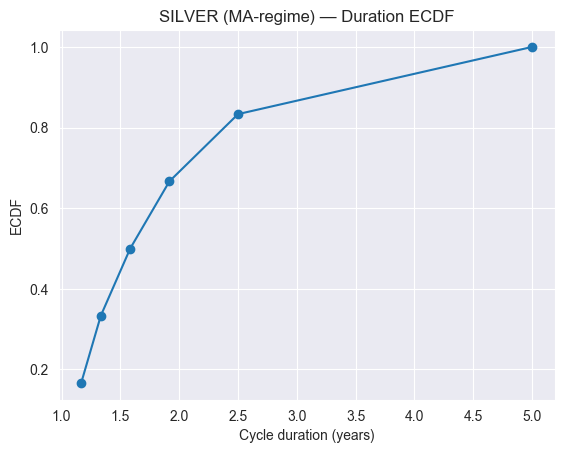

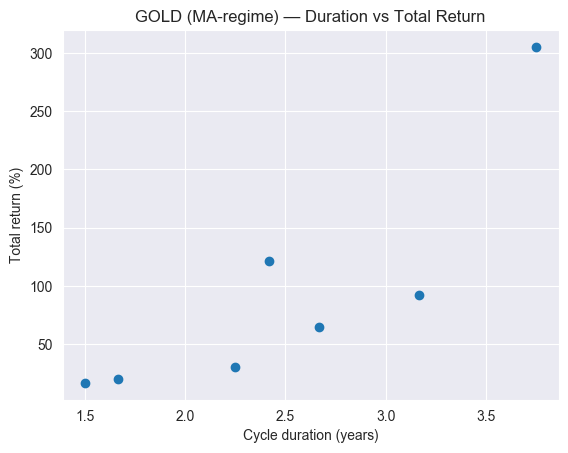

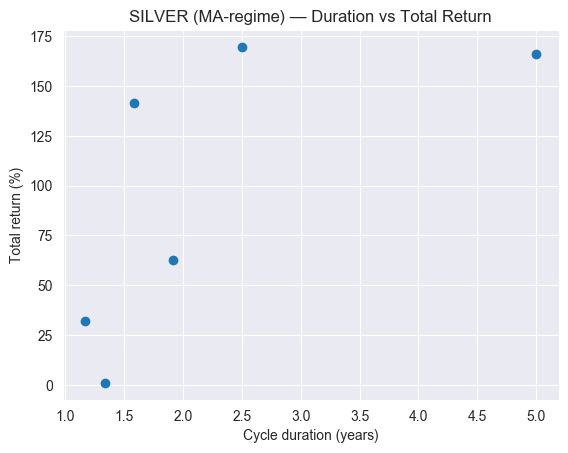

In [104]:
import os

def savefig(path: str, dpi: int = 300):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=dpi, bbox_inches="tight", facecolor="white")

def plot_price_with_ma_regime(
    price_m: pd.Series,
    cycles_ma: pd.DataFrame,
    title: str,
    out_path: str,          # e.g. "./img/Fig1_SILVER_price_regime.png"
    logy: bool = True
):
    price_m = price_m.dropna().sort_index()

    plt.figure(figsize=(10, 6))
    plt.plot(price_m.index, price_m.values)
    if logy:
        plt.yscale("log")

    if cycles_ma is not None and len(cycles_ma) > 0:
        for _, r in cycles_ma.iterrows():
            s = pd.Timestamp(r["start"])
            e = pd.Timestamp(r["end"])
            plt.axvspan(s, e, alpha=0.18)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (log)" if logy else "Price")
    
    format_year_ticks(step_years=5)  # ✅ 每x年显示一次年份

    savefig(out_path)
    plt.show()
    plt.close()


def plot_duration_hist(cycles_ma: pd.DataFrame, title: str, bins: int = 12):
    if cycles_ma is None or len(cycles_ma) == 0:
        print(f"[skip] {title}: empty cycles")
        return
    x = cycles_ma["years"].dropna().values

    plt.figure()
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.xlabel("Cycle duration (years)")
    plt.ylabel("Count")
    plt.show()


def plot_duration_ecdf(cycles_ma: pd.DataFrame, title: str):
    if cycles_ma is None or len(cycles_ma) == 0:
        print(f"[skip] {title}: empty cycles")
        return
    x = np.sort(cycles_ma["years"].dropna().values)
    y = np.arange(1, len(x) + 1) / len(x)

    plt.figure()
    plt.plot(x, y, marker="o", linestyle="-")
    plt.title(title)
    plt.xlabel("Cycle duration (years)")
    plt.ylabel("ECDF")
    plt.show()


def plot_duration_vs_return(cycles_ma: pd.DataFrame, title: str):
    if cycles_ma is None or len(cycles_ma) == 0:
        print(f"[skip] {title}: empty cycles")
        return
    x = cycles_ma["years"].values
    y = cycles_ma["total_return"].values * 100

    plt.figure()
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel("Cycle duration (years)")
    plt.ylabel("Total return (%)")
    plt.show()


# ----------------------------
# 1) Monthly price with MA-regime cycles shaded
# ----------------------------
gold_price = gold_m["Price"]
silver_price = silver_m["Price"]
# copper_price = copper_m["Price"]

plot_price_with_ma_regime(gold_price, gold_A, "GOLD — MA-regime bull cycles shaded", logy=True, out_path='./img/Fig1_GOLD_price_regime.png')
plot_price_with_ma_regime(silver_price, silver_A, "SILVER — MA-regime bull cycles shaded", logy=True, out_path='./img/Fig1_SILVER_price_regime.png')
# plot_price_with_ma_regime(copper_price, copper_A, "COPPER — MA-regime bull cycles shaded", logy=True)

# ----------------------------
# 2) Duration distributions (years) — MA-regime
# ----------------------------
plot_duration_hist(gold_A, "GOLD (MA-regime) — Cycle duration histogram", bins=10)
plot_duration_hist(silver_A, "SILVER (MA-regime) — Cycle duration histogram", bins=10)
# plot_duration_hist(copper_A, "COPPER (MA-regime) — Cycle duration histogram", bins=10)

plot_duration_ecdf(gold_A, "GOLD (MA-regime) — Duration ECDF")
plot_duration_ecdf(silver_A, "SILVER (MA-regime) — Duration ECDF")
# plot_duration_ecdf(copper_A, "COPPER (MA-regime) — Duration ECDF")

# ----------------------------
# 3) Duration vs total return (optional)
# ----------------------------
plot_duration_vs_return(gold_A, "GOLD (MA-regime) — Duration vs Total Return")
plot_duration_vs_return(silver_A, "SILVER (MA-regime) — Duration vs Total Return")
# plot_duration_vs_return(copper_A, "COPPER (MA-regime) — Duration vs Total Return")

In [73]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact

# ----------------------------
# 1) 干支与五行（1984=甲子基准）
# ----------------------------
STEMS = list("甲乙丙丁戊己庚辛壬癸")
BRANCHES = list("子丑寅卯辰巳午未申酉戌亥")

BASE_YEAR = 1984  # 甲子

def year_ganzhi(y: int):
    off = y - BASE_YEAR
    stem = STEMS[off % 10]
    branch = BRANCHES[off % 12]
    return stem, branch

# ----------------------------
# 2) Fire / WoodFire 三种定义
#   Fire-A: 年干丙丁
#   Fire-B: 年支巳午
#   Fire-C: 丙丁 or 巳午未 (按你口径，把未也算火)
#
#   WoodFire-A: 年干甲乙丙丁
#   WoodFire-B: 年支寅卯巳午 (不含未)
#   WoodFire-C: (干甲乙丙丁) or (支寅卯巳午未)  (最宽松，未也算火)
# ----------------------------
def is_fire_A(y: int) -> bool:
    stem, _ = year_ganzhi(y)
    return stem in {"丙", "丁"}

def is_fire_B(y: int) -> bool:
    _, branch = year_ganzhi(y)
    return branch in {"巳", "午", '未'}

def is_fire_C(y: int) -> bool:
    stem, branch = year_ganzhi(y)
    return (stem in {"丙", "丁"}) or (branch in {"巳", "午", "未"})

def is_woodfire_A(y: int) -> bool:
    stem, _ = year_ganzhi(y)
    return stem in {"甲", "乙", "丙", "丁"}

def is_woodfire_B(y: int) -> bool:
    _, branch = year_ganzhi(y)
    return branch in {"寅", "卯", "巳", "午", '未'}

def is_woodfire_C(y: int) -> bool:
    stem, branch = year_ganzhi(y)
    return (stem in {"甲", "乙", "丙", "丁"}) or (branch in {"寅", "卯", "巳", "午", "未"})

LABEL_DEFS = {
    "Fire-A(干丙丁)": is_fire_A,
    "Fire-B(支巳午未)": is_fire_B,
    "Fire-C(丙丁或巳午未)": is_fire_C,
    "WoodFire-A(干甲乙丙丁)": is_woodfire_A,
    "WoodFire-B(支寅卯巳午未)": is_woodfire_B,
    "WoodFire-C(甲乙丙丁或寅卯巳午未)": is_woodfire_C,
}

# # ----------------------------
# # 3) bull cycles -> bull months / tail months / surge months
# # ----------------------------
# def to_month_end_index(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
#     return pd.DatetimeIndex(idx).to_period("M").to_timestamp("M")
# 
# def expand_cycles_to_months(cycles: pd.DataFrame) -> pd.DatetimeIndex:
#     months = []
#     for _, r in cycles.iterrows():
#         s = pd.Timestamp(r["start"]).to_period("M").to_timestamp("M")
#         e = pd.Timestamp(r["end"]).to_period("M").to_timestamp("M")
#         months.extend(pd.date_range(s, e, freq="ME"))
#     return pd.DatetimeIndex(months).unique().sort_values()
# 
# def last_n_months_of_cycles(cycles: pd.DataFrame, n: int) -> pd.DatetimeIndex:
#     months = []
#     for _, r in cycles.iterrows():
#         s = pd.Timestamp(r["start"]).to_period("M").to_timestamp("M")
#         e = pd.Timestamp(r["end"]).to_period("M").to_timestamp("M")
#         rng = pd.date_range(s, e, freq="ME")
#         if len(rng) == 0:
#             continue
#         months.extend(rng[-min(n, len(rng)):])
#     return pd.DatetimeIndex(months).unique().sort_values()
# 
# def top_return_months_within_subset(price_m: pd.Series, subset_months: pd.DatetimeIndex, q: float) -> pd.DatetimeIndex:
#     """
#     在 subset_months 内，取月收益 top (1-q) 的月份。
#     q=0.8 -> 取 top20%
#     """
#     price_m = price_m.dropna().copy()
#     price_m.index = to_month_end_index(price_m.index)
# 
#     ret = price_m.pct_change()
#     subset_months = pd.DatetimeIndex(subset_months).intersection(ret.index)
#     r = ret.loc[subset_months].dropna()
#     if len(r) == 0:
#         return pd.DatetimeIndex([])
# 
#     thr = r.quantile(q)
#     return pd.DatetimeIndex(r.index[r >= thr]).sort_values()
# 
# # ----------------------------
# # 4) 富集检验（Fisher 单侧：subset 更富集于标签）
# #   对比：subset_months vs (all_months - subset_months)
# # ----------------------------
# def enrichment_test(subset_months: pd.DatetimeIndex, all_months: pd.DatetimeIndex, label_fn, alternative="greater"):
#     subset_months = pd.DatetimeIndex(subset_months).intersection(all_months)
#     other_months = all_months.difference(subset_months)
# 
#     a = sum(label_fn(dt.year) for dt in subset_months)   # subset & label
#     b = len(subset_months) - a                           # subset & not
#     c = sum(label_fn(dt.year) for dt in other_months)    # other & label
#     d = len(other_months) - c                            # other & not
# 
#     table = np.array([[a, b], [c, d]])
#     odds_ratio, p_value = fisher_exact(table, alternative=alternative)
# 
#     subset_rate = a / (a + b) if (a + b) else np.nan
#     base_rate = (a + c) / (a + b + c + d) if (a + b + c + d) else np.nan
# 
#     return {
#         "subset_rate": subset_rate,
#         "base_rate": base_rate,
#         "odds_ratio": odds_ratio,
#         "p_value": p_value,
#         "n_subset": len(subset_months),
#         "n_all": len(all_months),
#         "table": table,
#     }
# 
# # ----------------------------
# # 5) 统一跑：方案A（暴涨月）+ 方案B（冲顶段）+ 对照（全部bull月）
# # ----------------------------
# def run_A_B(asset_name: str, price_m: pd.Series, cycles: pd.DataFrame,
#             surge_q: float = 0.80,   # top20%
#             tail_n: int = 12,        # 最后12个月
#             alternative: str = "greater",
#             show_tables: bool = False):
# 
#     price_m = price_m.dropna().copy()
#     price_m.index = to_month_end_index(price_m.index)
#     all_months = pd.DatetimeIndex(price_m.index).sort_values()
# 
#     bull_months = expand_cycles_to_months(cycles)
#     bull_months = pd.DatetimeIndex(bull_months).intersection(all_months)
# 
#     tail_months = last_n_months_of_cycles(cycles, tail_n)
#     tail_months = pd.DatetimeIndex(tail_months).intersection(all_months)
# 
#     surge_months = top_return_months_within_subset(price_m, bull_months, q=surge_q)
#     surge_months = pd.DatetimeIndex(surge_months).intersection(all_months)
# 
#     subsets = {
#         f"ALL_BULL_MONTHS": bull_months,
#         f"A_SURGE(top{int((1-surge_q)*100)}% within bull)": surge_months,
#         f"B_TAIL(last_{tail_n}m of each bull)": tail_months,
#     }
# 
#     rows = []
#     for subset_name, subset_idx in subsets.items():
#         for def_name, fn in LABEL_DEFS.items():
#             res = enrichment_test(subset_idx, all_months, fn, alternative=alternative)
#             rows.append({
#                 "asset": asset_name,
#                 "subset": subset_name,
#                 "definition": def_name,
#                 "subset_rate_%": 100 * res["subset_rate"],
#                 "base_rate_%": 100 * res["base_rate"],
#                 "OR": res["odds_ratio"],
#                 "p": res["p_value"],
#                 "n_subset": res["n_subset"],
#                 "n_all": res["n_all"],
#             })
#             if show_tables:
#                 print(f"\n[{asset_name} | {subset_name} | {def_name}] 2x2:\n{res['table']}")
# 
#     out = pd.DataFrame(rows)
#     out["subset_rate_%"] = out["subset_rate_%"].round(2)
#     out["base_rate_%"] = out["base_rate_%"].round(2)
#     out["OR"] = out["OR"].round(3)
#     out["p"] = out["p"].round(6)
# 
#     # 按 subset 分组打印（每组按 p 从小到大）
#     print(f"\n=== {asset_name}: 方案A/B 与 火/木火 定义对比（Fisher 单侧: {alternative}） ===")
#     for subset_name in out["subset"].unique():
#         tmp = out[out["subset"] == subset_name].sort_values("p")
#         print(f"\n--- {subset_name} ---")
#         print(tmp.to_string(index=False))
# 
#     return out
# 
# # ----------------------------
# # 6) 运行（先 GOLD / SILVER，COPPER 你想加再开）
# # ----------------------------
# gold_out = run_A_B("GOLD", gold_price, gold_A, surge_q=0.80, tail_n=12, alternative="greater", show_tables=False)
# silver_out = run_A_B("SILVER", silver_price, silver_A, surge_q=0.80, tail_n=12, alternative="greater", show_tables=False)
# # copper_out = run_A_B("COPPER", copper_price, copper_A, surge_q=0.80, tail_n=12, alternative="greater", show_tables=False)


In [108]:

# ============================
# A方案（仅改这里）：用“加速段”而不是单月暴涨
# 定义：在 bull months 内，取过去 K 个月累计涨幅（momentum_K）
# 或未来 K 个月累计涨幅（forward_K，做事后识别主升浪）
# 选择 top (1-q) 分位作为“主升浪月份”
# ============================

def to_month_end_index(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    return pd.DatetimeIndex(idx).to_period("M").to_timestamp("M")

def expand_cycles_to_months(cycles: pd.DataFrame) -> pd.DatetimeIndex:
    months = []
    for _, r in cycles.iterrows():
        s = pd.Timestamp(r["start"]).to_period("M").to_timestamp("M")
        e = pd.Timestamp(r["end"]).to_period("M").to_timestamp("M")
        months.extend(pd.date_range(s, e, freq="ME"))
    return pd.DatetimeIndex(months).unique().sort_values()

def last_n_months_of_cycles(cycles: pd.DataFrame, n: int) -> pd.DatetimeIndex:
    months = []
    for _, r in cycles.iterrows():
        s = pd.Timestamp(r["start"]).to_period("M").to_timestamp("M")
        e = pd.Timestamp(r["end"]).to_period("M").to_timestamp("M")
        rng = pd.date_range(s, e, freq="ME")
        if len(rng) == 0:
            continue
        months.extend(rng[-min(n, len(rng)):])
    return pd.DatetimeIndex(months).unique().sort_values()

def enrichment_test(subset_months: pd.DatetimeIndex, all_months: pd.DatetimeIndex, label_fn, alternative="greater"):
    subset_months = pd.DatetimeIndex(subset_months).intersection(all_months)
    other_months = all_months.difference(subset_months)

    a = sum(label_fn(dt.year) for dt in subset_months)
    b = len(subset_months) - a
    c = sum(label_fn(dt.year) for dt in other_months)
    d = len(other_months) - c

    table = np.array([[a, b], [c, d]])
    odds_ratio, p_value = fisher_exact(table, alternative=alternative)

    subset_rate = a / (a + b) if (a + b) else np.nan
    base_rate = (a + c) / (a + b + c + d) if (a + b + c + d) else np.nan

    return {
        "subset_rate": subset_rate,
        "base_rate": base_rate,
        "odds_ratio": odds_ratio,
        "p_value": p_value,
        "n_subset": len(subset_months),
        "n_all": len(all_months),
        "table": table,
    }

# ---------- A方案新定义：加速段月份 ----------
def acceleration_months_within_bull(
    price_m: pd.Series,
    bull_months: pd.DatetimeIndex,
    q: float = 0.90,     # top10%
    K: int = 6,          # 6个月加速段
    mode: str = "past",  # "past" 用过去K个月累计涨幅（可用于当下）；"fwd" 用未来K个月累计涨幅（事后识别主升浪）
) -> pd.DatetimeIndex:
    """
    返回 bull months 内的“加速段月份”（top分位）
    """
    price_m = price_m.dropna().copy()
    price_m.index = to_month_end_index(price_m.index)
    bull_months = pd.DatetimeIndex(bull_months).intersection(price_m.index)

    logp = np.log(price_m)

    if mode == "past":
        score = (logp - logp.shift(K))  # past K-month log return
    elif mode == "fwd":
        score = (logp.shift(-K) - logp) # forward K-month log return (lookahead, 仅用于识别历史主升浪)
    else:
        raise ValueError("mode must be 'past' or 'fwd'")

    s = score.loc[bull_months].dropna()
    if len(s) == 0:
        return pd.DatetimeIndex([])

    thr = s.quantile(q)  # 取 top(1-q)
    accel = s.index[s >= thr]
    return pd.DatetimeIndex(accel).sort_values()

# ============================
# 下面这些保持不变：干支定义、火/木火定义、run_A_B 框架
# 只把 A_SURGE 的构造替换为 acceleration_months_within_bull
# ============================

# --- 你的干支/定义（直接复用你上一轮的 LABEL_DEFS） ---
# LABEL_DEFS = {...}  # 这里假设你已经在上面单元定义好（Fire-A/B/C & WoodFire-A/B/C）
# year_ganzhi(y) 也假设已定义好

def run_A_B_modified_A(
    asset_name: str,
    price_m: pd.Series,
    cycles: pd.DataFrame,
    accel_q: float = 0.90,   # top10%
    accel_K: int = 6,        # 6个月
    accel_mode: str = "past",
    tail_n: int = 12,
    alternative: str = "greater",
    show_tables: bool = False
):
    price_m = price_m.dropna().copy()
    price_m.index = to_month_end_index(price_m.index)
    all_months = pd.DatetimeIndex(price_m.index).sort_values()

    bull_months = expand_cycles_to_months(cycles)
    bull_months = pd.DatetimeIndex(bull_months).intersection(all_months)

    # B方案保持不变
    tail_months = last_n_months_of_cycles(cycles, tail_n)
    tail_months = pd.DatetimeIndex(tail_months).intersection(all_months)

    # A方案：改成“加速段月份”
    accel_months = acceleration_months_within_bull(
        price_m, bull_months, q=accel_q, K=accel_K, mode=accel_mode
    )
    accel_months = pd.DatetimeIndex(accel_months).intersection(all_months)

    subsets = {
        "ALL_BULL_MONTHS": bull_months,
        f"A_ACCEL(top{int((1-accel_q)*100)}% by {accel_K}m_{accel_mode})": accel_months,
        f"B_TAIL(last_{tail_n}m of each bull)": tail_months,
    }

    rows = []
    for subset_name, subset_idx in subsets.items():
        for def_name, fn in LABEL_DEFS.items():
            res = enrichment_test(subset_idx, all_months, fn, alternative=alternative)
            rows.append({
                "asset": asset_name,
                "subset": subset_name,
                "definition": def_name,
                "subset_rate_%": 100 * res["subset_rate"],
                "base_rate_%": 100 * res["base_rate"],
                "OR": res["odds_ratio"],
                "p": res["p_value"],
                "n_subset": res["n_subset"],
                "n_all": res["n_all"],
            })
            if show_tables:
                print(f"\n[{asset_name} | {subset_name} | {def_name}] 2x2:\n{res['table']}")

    out = pd.DataFrame(rows)
    out["subset_rate_%"] = out["subset_rate_%"].round(2)
    out["base_rate_%"] = out["base_rate_%"].round(2)
    out["OR"] = out["OR"].round(3)
    out["p"] = out["p"].round(6)

    print(f"\n=== {asset_name}: 仅改A方案为“加速段月份”（Fisher 单侧: {alternative}） ===")
    for subset_name in out["subset"].unique():
        tmp = out[out["subset"] == subset_name].sort_values("p")
        print(f"\n--- {subset_name} ---")
        print(tmp.to_string(index=False))

    return out

# ============================
# 运行（先 SILVER 建议用 past-6m + top10%）
# - accel_mode="past": 用过去6个月累计涨幅选“加速段”（无前视，可用于实盘框架）
# - 如需严格识别“历史主升浪”，也可试 accel_mode="fwd"（有前视，仅用于历史归因）
# ============================

gold_out2 = run_A_B_modified_A("GOLD", gold_price, gold_A, accel_q=0.85, accel_K=9, accel_mode="past", tail_n=3)
silver_out2 = run_A_B_modified_A("SILVER", silver_price, silver_A, accel_q=0.85, accel_K=9, accel_mode="past", tail_n=3)

# 可选：用 forward 6m 识别“事后主升浪”（仅用于验证叙事）
# silver_out2_fwd = run_A_B_modified_A("SILVER", silver_price, silver_A, accel_q=0.90, accel_K=6, accel_mode="fwd", tail_n=12)



=== GOLD: 仅改A方案为“加速段月份”（Fisher 单侧: greater） ===

--- ALL_BULL_MONTHS ---
asset          subset             definition  subset_rate_%  base_rate_%    OR        p  n_subset  n_all
 GOLD ALL_BULL_MONTHS     WoodFire-B(支寅卯巳午未)          54.07        43.04 1.978 0.000053       209    611
 GOLD ALL_BULL_MONTHS         Fire-C(丙丁或巳午未)          51.67        43.21 1.686 0.001561       209    611
 GOLD ALL_BULL_MONTHS           Fire-B(支巳午未)          32.06        25.53 1.659 0.005433       209    611
 GOLD ALL_BULL_MONTHS WoodFire-C(甲乙丙丁或寅卯巳午未)          76.56        70.54 1.578 0.011354       209    611
 GOLD ALL_BULL_MONTHS            Fire-A(干丙丁)          23.92        19.64 1.491 0.035835       209    611
 GOLD ALL_BULL_MONTHS      WoodFire-A(干甲乙丙丁)          40.67        41.08 0.975 0.592403       209    611

--- A_ACCEL(top15% by 9m_past) ---
asset                     subset             definition  subset_rate_%  base_rate_%    OR        p  n_subset  n_all
 GOLD A_ACCEL(top15% by 9m_past)       

In [76]:
from scipy.stats import fisher_exact

# Assumes already defined in your notebook:
# - LABEL_DEFS (Fire-A/B/C & WoodFire-A/B/C)
# - year_ganzhi(y)
# - expand_cycles_to_months(cycles)
# - to_month_end_index(idx)
# - enrichment_test(subset_months, all_months, label_fn, alternative="greater")

def grid_test_A_only(
    asset_name: str,
    price_m: pd.Series,
    cycles: pd.DataFrame,
    Ks=(6, 9, 12),
    qs=(0.80, 0.85, 0.90, 0.95),
    modes=("past",),              # add "fwd" if you want narrative-only validation
    alternative: str = "greater",
    definitions_keep=None,        # e.g., ["WoodFire-B(支寅卯巳午未)", "Fire-C(丙丁或巳午未)"]
):
    price_m = price_m.dropna().copy()
    price_m.index = to_month_end_index(price_m.index)
    all_months = pd.DatetimeIndex(price_m.index).sort_values()

    bull_months = expand_cycles_to_months(cycles)
    bull_months = pd.DatetimeIndex(bull_months).intersection(all_months)

    if definitions_keep is None:
        definitions_keep = list(LABEL_DEFS.keys())

    rows = []
    for mode in modes:
        for K in Ks:
            for q in qs:
                accel_months = acceleration_months_within_bull(
                    price_m=price_m,
                    bull_months=bull_months,
                    q=q,
                    K=K,
                    mode=mode
                )

                for def_name, fn in LABEL_DEFS.items():
                    if def_name not in definitions_keep:
                        continue

                    res = enrichment_test(accel_months, all_months, fn, alternative=alternative)

                    rows.append({
                        "asset": asset_name,
                        "mode": mode,
                        "K": K,
                        "q": q,
                        "top_pct": int(round((1 - q) * 100)),
                        "definition": def_name,
                        "n_subset": res["n_subset"],
                        "subset_rate_%": 100 * res["subset_rate"],
                        "base_rate_%": 100 * res["base_rate"],
                        "OR": res["odds_ratio"],
                        "p": res["p_value"],
                    })

    out = pd.DataFrame(rows)
    if out.empty:
        print(f"[{asset_name}] No results (empty). Check bull_months / price index alignment.")
        return out

    out["subset_rate_%"] = out["subset_rate_%"].round(2)
    out["base_rate_%"] = out["base_rate_%"].round(2)
    out["OR"] = out["OR"].round(3)
    out["p"] = out["p"].round(6)

    # Helpful ordering: by definition then lowest p
    out = out.sort_values(["definition", "p", "mode", "K", "q"]).reset_index(drop=True)

    print(f"\n=== {asset_name}: A方案网格（加速段） K={list(Ks)}, q={list(qs)}, mode={list(modes)} ===")
    # Print a compact view: best 10 rows per definition
    for def_name in definitions_keep:
        tmp = out[out["definition"] == def_name].sort_values("p").head(10)
        if len(tmp) == 0:
            continue
        print(f"\n--- {def_name} | best 10 (lowest p) ---")
        print(tmp[["mode","K","q","top_pct","n_subset","subset_rate_%","base_rate_%","OR","p"]].to_string(index=False))

    return out

# ----------------------------
# Recommended: start with SILVER, keep only the key definitions you care about
# e.g., WoodFire-B is the one that showed marginal evidence.
# ----------------------------
defs_focus = [
    "WoodFire-B(支寅卯巳午未)",
    "WoodFire-A(干甲乙丙丁)",
    "Fire-B(支巳午未)",
    "Fire-C(丙丁或巳午未)",
]

silver_grid = grid_test_A_only(
    asset_name="SILVER",
    price_m=silver_price,
    cycles=silver_A,
    Ks=(6, 9, 12),
    qs=(0.80, 0.85, 0.90, 0.95),
    modes=("past",),          # add "fwd" if you want narrative-only validation
    alternative="greater",
    definitions_keep=defs_focus
)

# If you also want GOLD with same grid:
gold_grid = grid_test_A_only(
    asset_name="GOLD",
    price_m=gold_price,
    cycles=gold_A,
    Ks=(6, 9, 12),
    qs=(0.80, 0.85, 0.90, 0.95),
    modes=("past",),
    alternative="greater",
    definitions_keep=defs_focus
)

# Optional: get a full table (no filtering) for SILVER
# silver_grid_full = grid_test_A_only("SILVER", silver_price, silver_A,
#                                     Ks=(6,9,12), qs=(0.80,0.85,0.90,0.95),
#                                     modes=("past",), alternative="greater",
#                                     definitions_keep=list(LABEL_DEFS.keys()))


=== SILVER: A方案网格（加速段） K=[6, 9, 12], q=[0.8, 0.85, 0.9, 0.95], mode=['past'] ===

--- WoodFire-B(支寅卯巳午未) | best 10 (lowest p) ---
mode  K    q  top_pct  n_subset  subset_rate_%  base_rate_%    OR        p
past  9 0.80       20        33          63.64        43.14 2.420 0.012082
past 12 0.90       10        17          70.59        43.14 3.267 0.019444
past 12 0.85       15        25          64.00        43.14 2.430 0.026382
past  6 0.90       10        17          64.71        43.14 2.478 0.058509
past  9 0.90       10        17          64.71        43.14 2.478 0.058509
past  6 0.80       20        33          57.58        43.14 1.850 0.062296
past 12 0.80       20        33          57.58        43.14 1.850 0.062296
past  9 0.85       15        25          60.00        43.14 2.036 0.063414
past  6 0.85       15        25          56.00        43.14 1.716 0.131687
past  6 0.95        5         9          66.67        43.14 2.674 0.136756

--- WoodFire-A(干甲乙丙丁) | best 10 (lowest p) 


=== Permutation Test | SILVER | WoodFire-B(支寅卯巳午未) ===
A_ACCEL definition: mode=past, K=9, q=0.8 (top 20%)
subset months (m) = 33 | bull months = 162
Observed rate = 63.64%
Null mean     = 38.74% (std 7.68%)
One-sided p   = 0.002000  [P(null >= observed)]


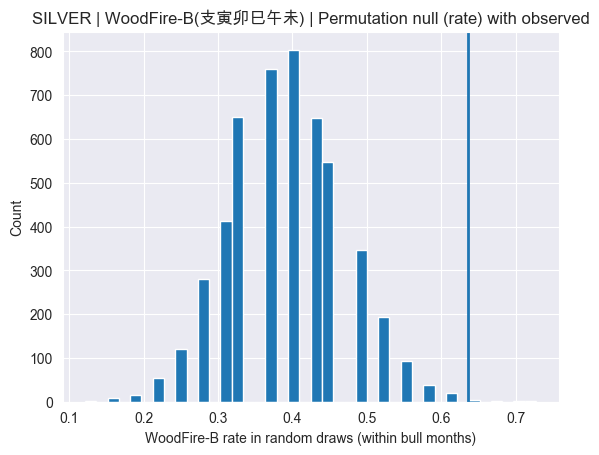

In [80]:
# ============================================================
# 3) 置换检验（Permutation Test）
#    目标：检验“加速段月份在 WoodFire-B 年份的占比”是否显著更高
#
#    Null：在 bull months 内随机抽取同样数量的月份（不改变数量），
#          计算木火旺占比。重复 N 次形成分布。
#    p-value（单侧）：P(null >= observed)
# ============================================================

def perm_test_enrichment_within_bull(
    bull_months: pd.DatetimeIndex,
    subset_months: pd.DatetimeIndex,
    label_fn,
    n_perm: int = 5000,
    seed: int = 42,
):
    bull_months = pd.DatetimeIndex(bull_months).unique().sort_values()
    subset_months = pd.DatetimeIndex(subset_months).intersection(bull_months).unique().sort_values()

    m = len(subset_months)
    if m == 0:
        raise ValueError("subset_months is empty after intersecting bull_months.")
    if len(bull_months) < m:
        raise ValueError("bull_months shorter than subset_months.")

    # observed
    obs = np.mean([label_fn(dt.year) for dt in subset_months])

    rng = np.random.default_rng(seed)
    bull_arr = bull_months.to_numpy()

    null_stats = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        draw = rng.choice(bull_arr, size=m, replace=False)
        null_stats[i] = np.mean([label_fn(pd.Timestamp(d).year) for d in draw])

    # one-sided p: how often null >= obs
    p = (np.sum(null_stats >= obs) + 1) / (n_perm + 1)

    # helpful summary
    return {
        "observed_rate": obs,
        "null_mean": float(null_stats.mean()),
        "null_std": float(null_stats.std(ddof=1)),
        "p_value_one_sided": float(p),
        "n_subset": m,
        "n_bull": len(bull_months),
        "null_stats": null_stats,  # keep if you want to plot histogram
    }


# ============================================================
# 4) 一键跑：指定资产、指定 A方案参数（K,q,mode），做置换检验
#    建议主结果先用你显著的点：K=9, q=0.80, mode="past"
# ============================================================

def run_perm_for_asset_A(
    asset_name: str,
    price_m: pd.Series,
    cycles: pd.DataFrame,
    K: int = 9,
    q: float = 0.80,
    mode: str = "past",
    n_perm: int = 5000,
    seed: int = 42,
    label_name: str = "WoodFire-B(支寅卯巳午未)",
    label_fn = is_woodfire_B,
):
    price_m = price_m.dropna().copy()
    price_m.index = to_month_end_index(price_m.index)

    bull_months = expand_cycles_to_months(cycles)
    bull_months = pd.DatetimeIndex(bull_months).intersection(price_m.index)

    subset_months = acceleration_months_within_bull(
        price_m=price_m,
        bull_months=bull_months,
        q=q,
        K=K,
        mode=mode,
    )

    res = perm_test_enrichment_within_bull(
        bull_months=bull_months,
        subset_months=subset_months,
        label_fn=label_fn,
        n_perm=n_perm,
        seed=seed,
    )

    print(f"\n=== Permutation Test | {asset_name} | {label_name} ===")
    print(f"A_ACCEL definition: mode={mode}, K={K}, q={q} (top {(1-q)*100:.0f}%)")
    print(f"subset months (m) = {res['n_subset']} | bull months = {res['n_bull']}")
    print(f"Observed rate = {res['observed_rate']:.2%}")
    print(f"Null mean     = {res['null_mean']:.2%} (std {res['null_std']:.2%})")
    print(f"One-sided p   = {res['p_value_one_sided']:.6f}  [P(null >= observed)]")

    return res


# ============================================================
# 5) Example: SILVER 主结果（你当前最稳的点之一）
# ============================================================

# 用你已有的 silver_price, silver_A
res_perm_silver = run_perm_for_asset_A(
    asset_name="SILVER",
    price_m=silver_price,
    cycles=silver_A,
    K=9,
    q=0.80,
    mode="past",
    n_perm=5000,
    seed=42,
    label_name="WoodFire-B(支寅卯巳午未)",
    label_fn=is_woodfire_B,
)

# 如需验证 K=12, q=0.90 的点也可再跑一次：
# res_perm_silver_12 = run_perm_for_asset_A("SILVER", silver_price, silver_A, K=12, q=0.90, mode="past")

# ----------------------------
# 2) 可选：画置换分布（直方图 + 观测值竖线）
# ----------------------------
plt.figure()
plt.hist(res_perm_silver["null_stats"], bins=40)
plt.axvline(res_perm_silver["observed_rate"], linewidth=2)
plt.title("SILVER | WoodFire-B(支寅卯巳午未) | Permutation null (rate) with observed")
plt.xlabel("WoodFire-B rate in random draws (within bull months)")
plt.ylabel("Count")
plt.show()



=== Permutation Test | GOLD | Fire-B(支巳午未) ===
A_ACCEL definition: mode=past, K=12, q=0.8 (top 20%)
subset months (m) = 42 | bull months = 209
Observed rate = 50.00%
Null mean     = 31.93% (std 6.43%)
One-sided p   = 0.005599  [P(null >= observed)]


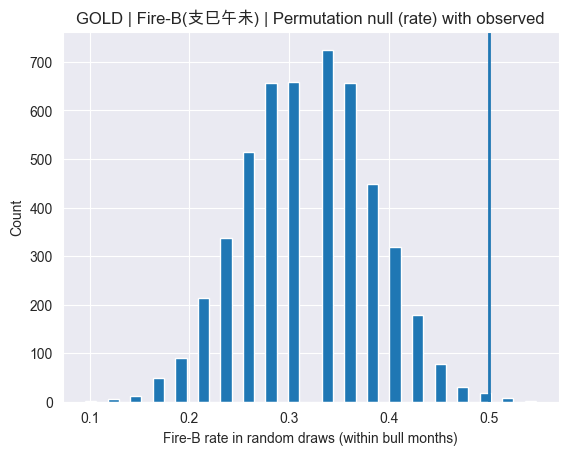

In [83]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# ----------------------------
# 1) GOLD 主结果：Fire-B, K=12, q=0.80, mode=past
# ----------------------------
def run_perm_gold_fireB_K12_q80(
    price_m: pd.Series,
    cycles: pd.DataFrame,
    n_perm: int = 20000,
    seed: int = 42
):
    price_m = price_m.dropna().copy()
    price_m.index = to_month_end_index(price_m.index)

    bull_months = expand_cycles_to_months(cycles)
    bull_months = pd.DatetimeIndex(bull_months).intersection(price_m.index)

    subset_months = acceleration_months_within_bull(
        price_m=price_m,
        bull_months=bull_months,
        q=0.80,     # top20%
        K=12,       # 12m past momentum
        mode="past"
    )

    res = perm_test_enrichment_within_bull(
        bull_months=bull_months,
        subset_months=subset_months,
        label_fn=is_fire_B,
        n_perm=n_perm,
        seed=seed
    )

    print("\n=== Permutation Test | GOLD | Fire-B(支巳午未) ===")
    print("A_ACCEL definition: mode=past, K=12, q=0.80 (top 20% within bull)")
    print(f"subset months (m) = {res['n_subset']} | bull months = {res['n_bull']}")
    print(f"Observed rate = {res['observed_rate']:.2%}")
    print(f"Null mean     = {res['null_mean']:.2%} (std {res['null_std']:.2%})")
    print(f"One-sided p   = {res['p_value_one_sided']:.6f}  [P(null >= observed)]")

    return res

# res_gold_perm = run_perm_gold_fireB_K12_q80(gold_price, gold_A, n_perm=20000, seed=42)
res_gold_perm = run_perm_for_asset_A(
    asset_name="GOLD",
    price_m=gold_price,
    cycles=gold_A,
    K=12,
    q=0.80,
    mode="past",
    n_perm=5000,
    seed=42,
    label_name="Fire-B(支巳午未)",
    label_fn=is_fire_B,
)

# ----------------------------
# 2) 可选：画置换分布（直方图 + 观测值竖线）
# ----------------------------
plt.figure()
plt.hist(res_gold_perm["null_stats"], bins=40)
plt.axvline(res_gold_perm["observed_rate"], linewidth=2)
plt.title("GOLD | Fire-B(支巳午未) | Permutation null (rate) with observed")
plt.xlabel("Fire-B rate in random draws (within bull months)")
plt.ylabel("Count")
plt.show()

In [84]:
# ----------------------------
# Robustness checks (Permutation)
# Use the same runner: run_perm_for_asset_A(...)
# ----------------------------

# 1) SILVER robustness: K=12, q=0.85
res_perm_silver_K12_q085 = run_perm_for_asset_A(
    asset_name="SILVER",
    price_m=silver_price,
    cycles=silver_A,
    K=12,
    q=0.85,
    mode="past",
    n_perm=5000,
    seed=42,
    label_name="WoodFire-B(支寅卯巳午未)",
    label_fn=is_woodfire_B,
)

# 2) SILVER robustness: K=12, q=0.90
res_perm_silver_K12_q090 = run_perm_for_asset_A(
    asset_name="SILVER",
    price_m=silver_price,
    cycles=silver_A,
    K=12,
    q=0.90,
    mode="past",
    n_perm=5000,
    seed=42,
    label_name="WoodFire-B(支寅卯巳午未)",
    label_fn=is_woodfire_B,
)

# 3) GOLD robustness: K=6, q=0.80
res_perm_gold_K6_q080 = run_perm_for_asset_A(
    asset_name="GOLD",
    price_m=gold_price,
    cycles=gold_A,
    K=6,
    q=0.80,
    mode="past",
    n_perm=5000,
    seed=42,
    label_name="Fire-B(支巳午未)",
    label_fn=is_fire_B,  # make sure your Fire-B label function is defined as 支巳午未
)

# Optional: quick summary print
def _summ(res):
    return {
        "observed_rate": round(100 * res["observed_rate"], 2),
        "null_mean": round(100 * res["null_mean"], 2),
        "null_std": round(100 * res["null_std"], 2),
        "p_one_sided": res["p_value_one_sided"],
        "n_subset": res["n_subset"],
        "n_bull": res["n_bull"],
    }

print("\n=== Permutation robustness summary ===")
print("SILVER | WoodFire-B | K=12 q=0.85:", _summ(res_perm_silver_K12_q085))
print("SILVER | WoodFire-B | K=12 q=0.90:", _summ(res_perm_silver_K12_q090))
print("GOLD   | Fire-B     | K=6  q=0.80:", _summ(res_perm_gold_K6_q080))



=== Permutation Test | SILVER | WoodFire-B(支寅卯巳午未) ===
A_ACCEL definition: mode=past, K=12, q=0.85 (top 15%)
subset months (m) = 25 | bull months = 162
Observed rate = 64.00%
Null mean     = 38.69% (std 8.98%)
One-sided p   = 0.003399  [P(null >= observed)]

=== Permutation Test | SILVER | WoodFire-B(支寅卯巳午未) ===
A_ACCEL definition: mode=past, K=12, q=0.9 (top 10%)
subset months (m) = 17 | bull months = 162
Observed rate = 70.59%
Null mean     = 38.80% (std 11.09%)
One-sided p   = 0.007399  [P(null >= observed)]

=== Permutation Test | GOLD | Fire-B(支巳午未) ===
A_ACCEL definition: mode=past, K=6, q=0.8 (top 20%)
subset months (m) = 42 | bull months = 209
Observed rate = 47.62%
Null mean     = 31.93% (std 6.43%)
One-sided p   = 0.011798  [P(null >= observed)]

=== Permutation robustness summary ===
SILVER | WoodFire-B | K=12 q=0.85: {'observed_rate': np.float64(64.0), 'null_mean': 38.69, 'null_std': 8.98, 'p_one_sided': 0.0033993201359728054, 'n_subset': 25, 'n_bull': 162}
SILVER | WoodFi

## Report Creation

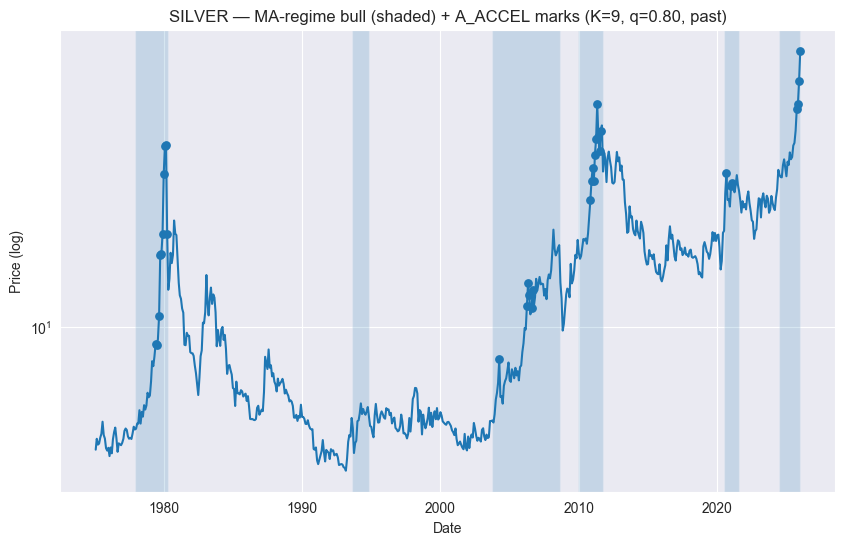

In [96]:
def plot_price_regime_with_marks(
    price_m: pd.Series,
    cycles_ma: pd.DataFrame,
    mark_months: pd.DatetimeIndex,
    title: str,
    out_path: str,
    logy: bool = True
):
    p = price_m.dropna().sort_index().copy()
    p.index = pd.DatetimeIndex(p.index).to_period("M").to_timestamp("M")

    marks = pd.DatetimeIndex(mark_months).to_period("M").to_timestamp("M")
    marks = marks.intersection(p.index)

    plt.figure(figsize=(10, 6))
    plt.plot(p.index, p.values)
    if logy:
        plt.yscale("log")

    # shade bull cycles
    if cycles_ma is not None and len(cycles_ma) > 0:
        for _, r in cycles_ma.iterrows():
            s = pd.Timestamp(r["start"]).to_period("M").to_timestamp("M")
            e = pd.Timestamp(r["end"]).to_period("M").to_timestamp("M")
            plt.axvspan(s, e, alpha=0.18)

    # mark accel months
    if len(marks) > 0:
        plt.scatter(marks, p.loc[marks].values, s=28)  # 不指定颜色，遵循你要求

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (log)" if logy else "Price")

    savefig(out_path)
    plt.show()
    plt.close()
    
bull_months = expand_cycles_to_months(silver_A)
accel_months = acceleration_months_within_bull(
    price_m=silver_price, bull_months=bull_months, K=9, q=0.80, mode="past"
)

plot_price_regime_with_marks(
    price_m=silver_price,
    cycles_ma=silver_A,
    mark_months=accel_months,
    title="SILVER — MA-regime bull (shaded) + A_ACCEL marks (K=9, q=0.80, past)",
    out_path="./img/Fig2_SILVER_accel_marks_K9_q080.png",
    logy=True
)

In [105]:
import matplotlib.patheffects as pe

def collect_perm_grid(
    asset_name: str,
    price_m: pd.Series,
    cycles: pd.DataFrame,
    label_fn,
    label_name: str,
    Ks=(6,9,12),
    qs=(0.80,0.85,0.90,0.95),
    mode="past",
    n_perm=5000,
    seed=42,
):
    rows = []
    bull_months = expand_cycles_to_months(cycles)
    for K in Ks:
        for q in qs:
            subset_months = acceleration_months_within_bull(
                price_m=price_m, bull_months=bull_months, K=K, q=q, mode=mode
            )
            res = perm_test_enrichment_within_bull(
                bull_months=pd.DatetimeIndex(bull_months).intersection(to_month_end_index(price_m.dropna().index)),
                subset_months=subset_months,
                label_fn=label_fn,
                n_perm=n_perm,
                seed=seed
            )
            rows.append({
                "asset": asset_name,
                "label": label_name,
                "mode": mode,
                "K": K,
                "q": q,
                "top_pct": int(round((1-q)*100)),
                "m": res["n_subset"],
                "observed": res["observed_rate"],
                "null_mean": res["null_mean"],
                "uplift": res["observed_rate"] - res["null_mean"],
                "p": res["p_value_one_sided"],
            })
    return pd.DataFrame(rows)


def plot_heatmap(df, value_col, title, out_path, fmt=None, is_p=False):
    pivot = df.pivot(index="q", columns="K", values=value_col).sort_index(ascending=False)

    plt.figure(figsize=(7.5, 5.5))
    im = plt.imshow(pivot.values, aspect="auto")
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.yticks(range(len(pivot.index)), [f"{x:.2f}" for x in pivot.index])
    plt.xlabel("K (months)")
    plt.ylabel("q (quantile)")
    plt.title(title)
    plt.colorbar(im)

    # 用 colormap + normalize 获取每个格子的 rgba，算亮度决定字色
    cmap = im.get_cmap()
    norm = im.norm

    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if np.isnan(val):
                text = "NA"
            else:
                if fmt is not None:
                    text = fmt(val)
                else:
                    text = f"{val:.3f}" if not is_p else f"{val:.4f}"

            # 计算格子底色亮度（0~1）
            rgba = cmap(norm(val)) if not np.isnan(val) else (1,1,1,1)
            r, g, b, _ = rgba
            luminance = 0.2126*r + 0.7152*g + 0.0722*b
            text_color = "black" if luminance > 0.55 else "white"

            t = plt.text(j, i, text, ha="center", va="center", fontsize=10, color=text_color)

            # 描边：无论黑字白字，都加对比描边
            edge = "white" if text_color == "black" else "black"
            t.set_path_effects([pe.withStroke(linewidth=2.5, foreground=edge)])

    savefig(out_path)
    plt.show()
    plt.close()


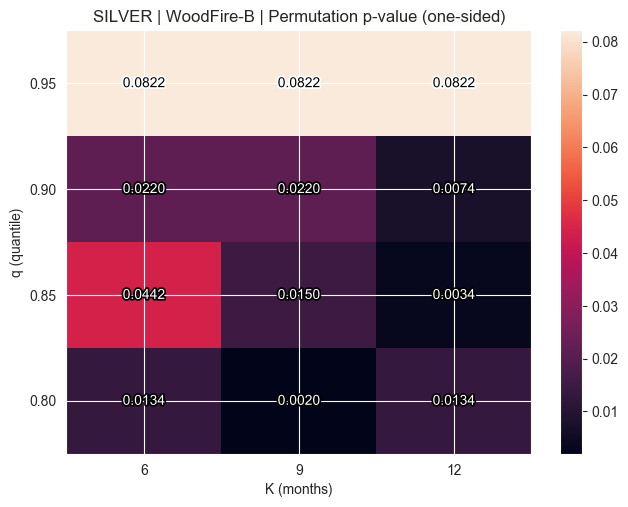

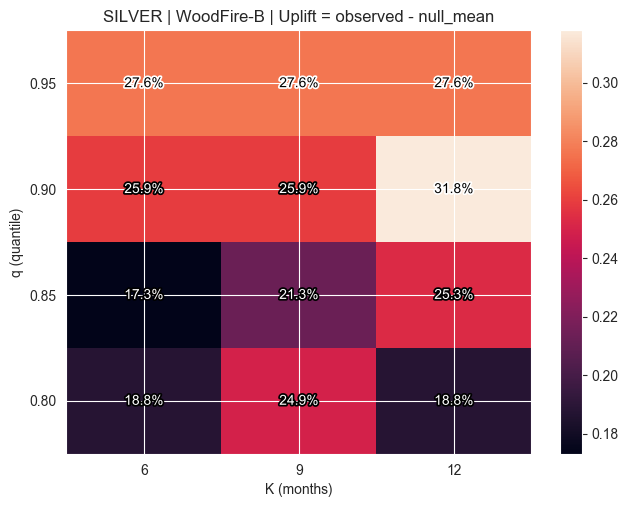

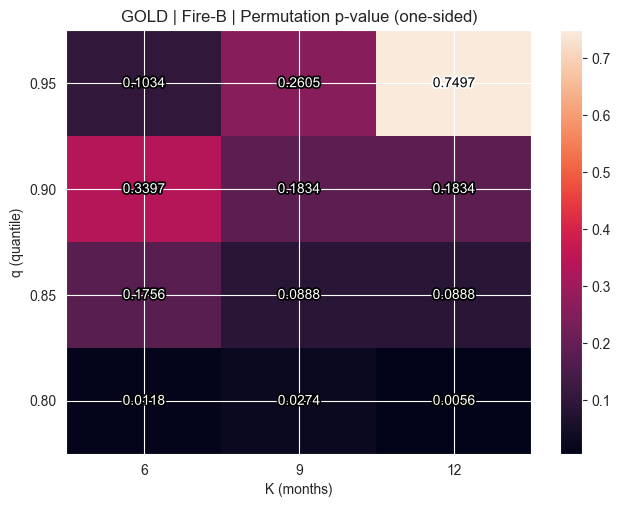

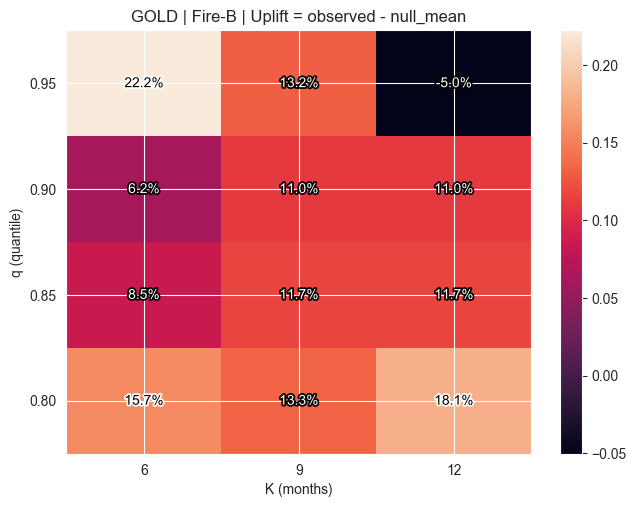

In [106]:
silver_perm_grid = collect_perm_grid(
    "SILVER", silver_price, silver_A,
    label_fn=is_woodfire_B,
    label_name="WoodFire-B(支寅卯巳午未)",
    Ks=(6,9,12),
    qs=(0.80,0.85,0.90,0.95),
    mode="past",
    n_perm=5000,
    seed=42
)

plot_heatmap(
    silver_perm_grid, "p",
    title="SILVER | WoodFire-B | Permutation p-value (one-sided)",
    out_path="./img/Fig4_SILVER_heatmap_p.png",
    is_p=True
)

plot_heatmap(
    silver_perm_grid, "uplift",
    title="SILVER | WoodFire-B | Uplift = observed - null_mean",
    out_path="./img/Fig4_SILVER_heatmap_uplift.png",
    fmt=lambda x: f"{100*x:.1f}%"  # 显示百分点
)


gold_perm_grid = collect_perm_grid(
    "GOLD", gold_price, gold_A,
    label_fn=is_fire_B,
    label_name="Fire-B(支巳午未)",
    Ks=(6,9,12),
    qs=(0.80,0.85,0.90,0.95),
    mode="past",
    n_perm=5000,
    seed=42
)

plot_heatmap(gold_perm_grid, "p",
             "GOLD | Fire-B | Permutation p-value (one-sided)",
             "./img/Fig4_GOLD_heatmap_p.png", is_p=True)
plot_heatmap(gold_perm_grid, "uplift",
             "GOLD | Fire-B | Uplift = observed - null_mean",
             "./img/Fig4_GOLD_heatmap_uplift.png",
             fmt=lambda x: f"{100*x:.1f}%")


In [99]:
def result_row(asset, label, K, q, mode, res):
    return {
        "asset": asset,
        "label": label,
        "mode": mode,
        "K": K,
        "q": q,
        "top_pct": int(round((1-q)*100)),
        "bull_months": res["n_bull"],
        "subset_months": res["n_subset"],
        "observed_%": round(100*res["observed_rate"], 2),
        "null_mean_%": round(100*res["null_mean"], 2),
        "null_std_%": round(100*res["null_std"], 2),
        "uplift_pp": round(100*(res["observed_rate"]-res["null_mean"]), 2),  # percentage points
        "p_perm_one_sided": res["p_value_one_sided"],
    }

summary_table = pd.DataFrame([
    result_row("SILVER","WoodFire-B(支寅卯巳午未)",9,0.80,"past",res_perm_silver),
    result_row("SILVER","WoodFire-B(支寅卯巳午未)",12,0.85,"past",res_perm_silver_K12_q085),
    result_row("SILVER","WoodFire-B(支寅卯巳午未)",12,0.90,"past",res_perm_silver_K12_q090),
    result_row("GOLD","Fire-B(支巳午未)",12,0.80,"past",res_gold_perm),
    result_row("GOLD","Fire-B(支巳午未)",6,0.80,"past",res_perm_gold_K6_q080),
]).sort_values(["asset","p_perm_one_sided"])

# 
# # 可选：导出到CSV，直接插入报告
summary_table.to_csv("./img/perm_summary_table.csv", index=False)


In [100]:
summary_table

,asset,label,mode,K,q,top_pct,bull_months,subset_months,observed_%,null_mean_%,null_std_%,uplift_pp,p_perm_one_sided
3,GOLD,Fire-B(支巳午未),past,12,0.80,20,209,42,50.00,31.93,6.43,18.07,0.005599
4,GOLD,Fire-B(支巳午未),past,6,0.80,20,209,42,47.62,31.93,6.43,15.69,0.011798
0,SILVER,WoodFire-B(支寅卯巳午未),past,9,0.80,20,162,33,63.64,38.74,7.68,24.90,0.002000
1,SILVER,WoodFire-B(支寅卯巳午未),past,12,0.85,15,162,25,64.00,38.69,8.98,25.31,0.003399
2,SILVER,WoodFire-B(支寅卯巳午未),past,12,0.90,10,162,17,70.59,38.80,11.09,31.79,0.007399
